In [1]:
import numpy as np

from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D,
    MaxPool2D,
    UpSampling2D
)

import matplotlib.pyplot as plt
%matplotlib inline

from utils import config_gpu
_ = config_gpu()

/home/youjin2/venvs/py3/lib/python3.6/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


## brief summary
* CAE: convolutional auto-encoder
* DAE: denoising auto-encoder

## load mnist

In [2]:
(x_train, _), (x_test, _) = mnist.load_data()

In [3]:
x_train.shape

(60000, 28, 28)

In [4]:
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

In [5]:
x_train.min(), x_train.max()

(0, 255)

## normalize

In [6]:
x_train = x_train/255.
x_test = x_test/255.

## noise mask

In [7]:
def make_masking_noise_data(data_x, percent=0.1):
    size = data_x.shape
    masking = np.random.binomial(n=1, p=percent, size=size)
    return data_x*masking


def make_gaussian_noise_data(data_x, scale=0.8):
    gaussian_data_x = data_x + np.random.normal(loc=0,
                                                scale=scale,
                                                size=data_x.shape)
    gaussian_data_x = np.clip(gaussian_data_x, 0, 1)
    return gaussian_data_x

In [8]:
x_train_masked = make_masking_noise_data(x_train)
x_test_masked = make_masking_noise_data(x_test)

x_train_gauss = make_gaussian_noise_data(x_train)
x_test_gauss = make_gaussian_noise_data(x_test)

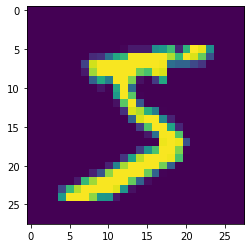

In [9]:
plt.imshow(x_train[0, :, :, 0])

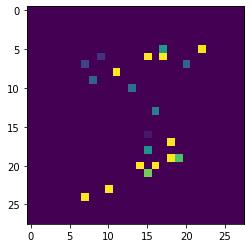

In [10]:
plt.imshow(x_train_masked[0, :, :, 0])

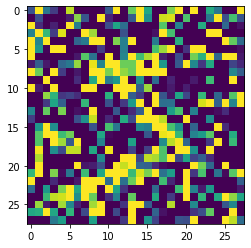

In [11]:
plt.imshow(x_train_gauss[0, :, :, 0])

## build CAE (with gaussian noise inputs)

In [12]:
autoencoder = Sequential()

In [13]:
# encoder
autoencoder.add(
    Conv2D(
        filters=16,
        kernel_size=(3, 3),
        strides=(1, 1),
        activation='relu',
        padding='same',
        input_shape=(28, 28, 1)
    )
)
autoencoder.add(
    MaxPool2D(
        pool_size=(2, 2),
        padding='same'
    )
)
autoencoder.add(
    Conv2D(
        filters=8,
        kernel_size=(3, 3),
        strides=(1, 1),
        activation='relu',
        padding='same',
    )
)
autoencoder.add(
    MaxPool2D(
        pool_size=(2, 2),
        padding='same'
    )
)

In [14]:
# decoder
autoencoder.add(
    Conv2D(
        filters=8,
        kernel_size=(3, 3),
        strides=(1, 1),
        activation='relu',
        padding='same',
    )
)
autoencoder.add(
    UpSampling2D(size=(2, 2))
)
autoencoder.add(
    Conv2D(
        filters=16,
        kernel_size=(3, 3),
        strides=(1, 1),
        activation='relu',
        padding='same',
    )
)
autoencoder.add(
    UpSampling2D(size=(2, 2))
)
autoencoder.add(
    Conv2D(
        filters=1,
        kernel_size=(3, 3),
        strides=(1, 1),
        activation='sigmoid',
        padding='same',
    )
)

In [15]:
autoencoder.compile(
    optimizer='adam',
    loss='binary_crossentropy'
)

In [16]:
initial_weights = autoencoder.get_weights()

In [17]:
autoencoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 8)           584       
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 14, 14, 8)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 16)        1

In [18]:
autoencoder.fit(
    x_train_gauss, # input: gaussian noise data
    x_train, # answer: original imgae
    epochs=10,
    batch_size=128,
    shuffle=True
)

Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 6s 102us/sample - loss: 0.2409
Epoch 2/10
60000/60000 [==============================] - 4s 68us/sample - loss: 0.1718
Epoch 3/10
60000/60000 [==============================] - 5s 81us/sample - loss: 0.1655
Epoch 4/10
60000/60000 [==============================] - 5s 86us/sample - loss: 0.1620
Epoch 5/10
60000/60000 [==============================] - 5s 86us/sample - loss: 0.1599
Epoch 6/10
60000/60000 [==============================] - 5s 86us/sample - loss: 0.1582
Epoch 7/10
60000/60000 [==============================] - 5s 86us/sample - loss: 0.1571
Epoch 8/10
60000/60000 [==============================] - 5s 86us/sample - loss: 0.1560
Epoch 9/10
60000/60000 [==============================] - 5s 86us/sample - loss: 0.1553
Epoch 10/10
60000/60000 [==============================] - 5s 85us/sample - loss: 0.1546


In [19]:
gauss_preds = autoencoder.predict(x_test_gauss)

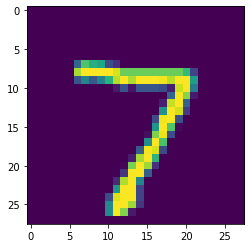

In [22]:
plt.imshow(x_test[0, :, :, 0])

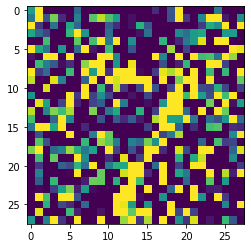

In [23]:
plt.imshow(x_test_gauss[0, :, :, 0])

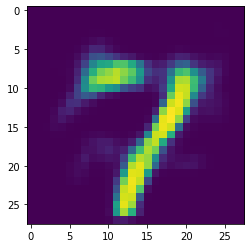

In [24]:
plt.imshow(gauss_preds[0, :, :, 0])

## build CAE (with masked inputs)

In [25]:
autoencoder.set_weights(initial_weights)

In [26]:
autoencoder.fit(
    x_train_masked, # input: gaussian noise data
    x_train, # answer: original imgae
    epochs=10,
    batch_size=128,
    shuffle=True
)

Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 5s 81us/sample - loss: 0.2434
Epoch 2/10
60000/60000 [==============================] - 5s 85us/sample - loss: 0.2011
Epoch 3/10
60000/60000 [==============================] - 5s 79us/sample - loss: 0.1971
Epoch 4/10
60000/60000 [==============================] - 5s 85us/sample - loss: 0.1944
Epoch 5/10
60000/60000 [==============================] - 5s 85us/sample - loss: 0.1925
Epoch 6/10
60000/60000 [==============================] - 5s 85us/sample - loss: 0.1908
Epoch 7/10
60000/60000 [==============================] - 5s 78us/sample - loss: 0.1895
Epoch 8/10
60000/60000 [==============================] - 4s 74us/sample - loss: 0.1884
Epoch 9/10
60000/60000 [==============================] - 5s 85us/sample - loss: 0.1875
Epoch 10/10
60000/60000 [==============================] - 5s 85us/sample - loss: 0.1868


In [32]:
masked_preds = autoencoder.predict(x_test_masked)

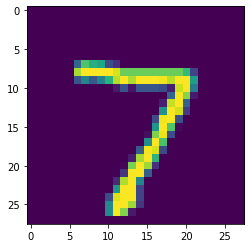

In [33]:
plt.imshow(x_test[0, :, :, 0])

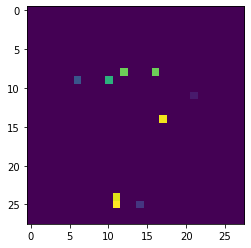

In [34]:
plt.imshow(x_test_masked[0, :, :, 0])

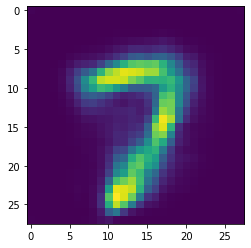

In [36]:
plt.imshow(masked_preds[0, :, :, 0])